# PINN: Poisson
Solving the poisson equation in 2D using the PINN-concept.

In [1]:
import torch
import torchphysics as tp

First, we create the spaces for our problem. These define the variable names which will be used in the remaining part of this code.

In this example, x is the space variable and u is the variable for the (1D-)solution. For more complex problems, spaces could also be built as cartesian products using the * operator

In [2]:
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')

As a next step, we build the domain of the problem. There are multiple options to build multi-dimensional domains - in this case, we simply create a circle and cut a square in its center.

In [3]:
A = tp.domains.Circle(X, center=[0, 0], radius=1.0)
B = tp.domains.Parallelogram(X, [-0.25, -0.25], [-0.25, 0.25], [0.25, -0.25])

# cutting operation:
D = A-B

Before we visualize the created domain, we create Sampler objects which are iterators that sample points from the domain during the optimization task. There are again various options to sample from the domains, an easy way would be to sample uniformly distributed random points.

In [4]:
inner_sampler = tp.samplers.RandomUniformSampler(D, density=1e3)
boundary_sampler = tp.samplers.RandomUniformSampler(D.boundary, density=1e3)

We visualize the domain through the points created by the samplers using matplotlib:

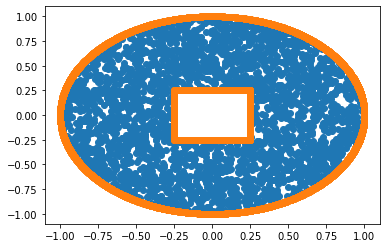

In [5]:
inner_points = next(inner_sampler)
boundary_points = next(boundary_sampler)

from matplotlib import pyplot as plt

plt.scatter(inner_points.as_tensor[:,0],
            inner_points.as_tensor[:,1])

plt.scatter(boundary_points.as_tensor[:,0],
            boundary_points.as_tensor[:,1])

In the next step we define the NN-model we want to fit to the PDE and a Condition which aims to minimze the residual of the poisson equation.

In [6]:
model = tp.models.FCN(input_space=X, output_space=U, hidden=(20,20,20))

def poisson_residual(u, x):
    return tp.utils.laplacian(u, x)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=poisson_residual)

Additionally, we add a boundary condition at the boundary of the domain:

In [7]:
def f(x):
    return torch.cos(x[:, :1])*torch.cos(x[:, 1:])

def boundary_residual(u, f):
    return u - f

boundary_condition = tp.conditions.PINNCondition(module=model,
                                                 sampler=boundary_sampler,
                                                 residual_fn=boundary_residual,
                                                 data_functions={'f': f})

Finally, we optimize the conditions using a pytorch-lightning.LightningModule Solver and running the training. In the Solver, the training and validation conditions, as well as all optimizer options can be specified.

In [8]:
solver = tp.solver.Solver([pde_condition,
                           boundary_condition])

import pytorch_lightning as pl

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # set GPU

trainer = pl.Trainer(gpus=1, # or None for CPU
                     max_steps=2000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 921   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Finally, we plot the obtained solution:

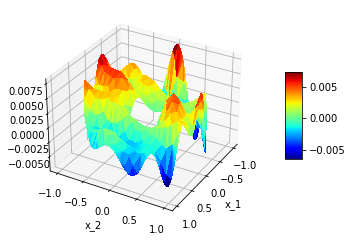

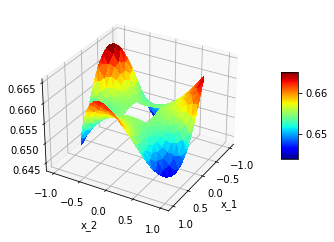

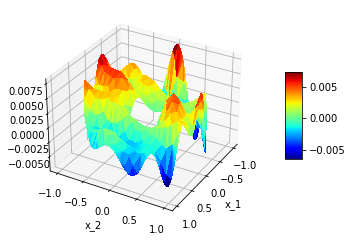

In [ ]:
tp.utils.plot(model, lambda u: u[:, 0], tp.samplers.PlotSampler(D, density=100))
# the handed lambda function could also used to plot the laplacian
tp.utils.plot(model, lambda u, x: tp.utils.laplacian(u, x), tp.samplers.PlotSampler(D, density=100))
